## Feature Detection + Matching

1. **Detection**
    * SIFT, Harris Corner, Affine SIFT 


2. **Matching**
    * Brute-Force 



3. **Post-processing**
    * Ransac algorithm, Filtering
    
**Libraries:**
- opencv2
- matplotlib
- numpy

In [1]:
%matplotlib inline

from cv2 import cv2
from matplotlib import pyplot as plt
import numpy as np
import json
import yaml
import re

plt.rcParams['figure.figsize'] = [13, 7]

In [2]:
# не забыть потом увеличить количество рассматриваемых кадров (вспомнить про отличные наименования)
#
#          ссылка на картинку               ссылка на боксы
frames = [(f'images/cam{i}/frame-{j}.png', f'frames/cam{i}/frame_{j}.yml') \
                                      for i in range(2) for j in range(6237, 6241)]
frames[0]

('images/cam0/frame-6237.png', 'frames/cam0/frame_6237.yml')

### Чтение .yaml файлов

In [3]:
# функция, корректирующая yaml файл, сгенерированный с помощью OpenCV, в формат,
# который может прочитать питон (библиотека yaml)

def readYAMLFile(file):
    ret = {}
    skip_lines = 1    # Skip the first line which says "%YAML:1.0". Or replace it with "%YAML 1.0"
    with open(file) as fin:
        for i in range(skip_lines):
            fin.readline()
        yamlFileOut = fin.read()
        myRe = re.compile(r":([^ ])")   # Add space after ":", if it doesn't exist. Python yaml requirement
        yamlFileOut = myRe.sub(r': \1', yamlFileOut)
        ret = yaml.safe_load(yamlFileOut)
    return ret

In [4]:
# боксы, ограничивающие объекты на конкретном снимке        \/
data = [readYAMLFile(frame[1])['boxes'] for frame in frames[:2]]

data[0][11] # 0 объект 0 кадра

{'id': 11,
 'conf': 0.465576171875,
 'class': 'car',
 'x_min': 290,
 'y_min': 319,
 'x_max': 476,
 'y_max': 517}

In [5]:
data[1][6]

{'id': 21,
 'conf': 0.64111328125,
 'class': 'car',
 'x_min': 313,
 'y_min': 308,
 'x_max': 483,
 'y_max': 485}

In [6]:
# пытаюсь не запутаться с SIFT

sift = cv2.SIFT_create()
features = {}
defective = []

for frame in frames[:2]:
    image = cv2.imread(frame[0], cv2.IMREAD_GRAYSCALE)
    features[frame[0][-14:-4]] = []
    
    for obj in readYAMLFile(frame[1])['boxes']:
        crop_image = image[obj['y_min']: obj['y_max'], obj['x_min']: obj['x_max']]
        
        kp, des = sift.detectAndCompute(crop_image, None)
        features[frame[0][-14:-4]].append({'id': obj['id'], 'kp': kp, 'des': des})
        
        if kp == ():
            defective.append(obj['id'])

defective

[5, 9, 12, 13, 25, 26, 28, 29]

In [7]:
def process_2_objects(obj1, obj2, bf):
    # проверка на существование найденных ключевых точек
    des1, des2 = obj1['des'], obj2['des']
    if des1 is None or des2 is None:
        return [(obj1['id'], obj2['id']), 0, 0]
    
    # print('matching between object with ids {} and {}:'.format(obj1['id'], obj2['id']))
    
    # 1 stage
    ab_matches = bf.knnMatch(des1, des2, k=2)
    ba_matches = bf.knnMatch(des2, des1, k=2)
    # print(f'\t1. sift featuring + "standart" bruteforce matching: {len(matches)} matches')
    
    # 2 stage
    good = []
    for m, n in max(ab_matches, ba_matches, key=len):
        if m.distance < 0.75 * n.distance:
            good.append([m])
    # print(f'\t2. after applying ration test: {len(good)} matches\n')
    
    return [(obj1['id'], obj2['id']), len(ab_matches), len(ba_matches), len(good)]

In [8]:
sift_matching = []
brf = cv2.BFMatcher()
for i in list(features.values())[0]:
    for j in list(features.values())[1]:
        sift_matching.append(process_2_objects(i, j, brf))

In [9]:
sift_matching

[[(0, 15), 5, 9, 0],
 [(0, 16), 5, 11, 3],
 [(0, 17), 5, 26, 1],
 [(0, 18), 5, 12, 0],
 [(0, 19), 5, 26, 1],
 [(0, 20), 5, 31, 5],
 [(0, 21), 5, 129, 17],
 [(0, 22), 5, 105, 4],
 [(0, 23), 5, 36, 0],
 [(0, 24), 5, 3, 0],
 [(0, 25), 0, 0],
 [(0, 26), 0, 0],
 [(0, 27), 5, 3, 1],
 [(0, 28), 0, 0],
 [(0, 29), 0, 0],
 [(1, 15), 12, 9, 4],
 [(1, 16), 12, 11, 0],
 [(1, 17), 12, 26, 0],
 [(1, 18), 12, 12, 0],
 [(1, 19), 12, 26, 3],
 [(1, 20), 12, 31, 1],
 [(1, 21), 12, 129, 6],
 [(1, 22), 12, 105, 5],
 [(1, 23), 12, 36, 0],
 [(1, 24), 12, 3, 2],
 [(1, 25), 0, 0],
 [(1, 26), 0, 0],
 [(1, 27), 12, 3, 0],
 [(1, 28), 0, 0],
 [(1, 29), 0, 0],
 [(2, 15), 29, 9, 0],
 [(2, 16), 29, 11, 3],
 [(2, 17), 29, 26, 0],
 [(2, 18), 29, 12, 0],
 [(2, 19), 29, 26, 0],
 [(2, 20), 29, 31, 10],
 [(2, 21), 29, 129, 13],
 [(2, 22), 29, 105, 11],
 [(2, 23), 29, 36, 1],
 [(2, 24), 29, 3, 4],
 [(2, 25), 0, 0],
 [(2, 26), 0, 0],
 [(2, 27), 29, 3, 3],
 [(2, 28), 0, 0],
 [(2, 29), 0, 0],
 [(3, 15), 15, 9, 0],
 [(3, 16), 15

In [10]:
representative = [x for x in sift_matching if x[0][0] not in defective and x[0][1] not in defective]
representative

[[(0, 15), 5, 9, 0],
 [(0, 16), 5, 11, 3],
 [(0, 17), 5, 26, 1],
 [(0, 18), 5, 12, 0],
 [(0, 19), 5, 26, 1],
 [(0, 20), 5, 31, 5],
 [(0, 21), 5, 129, 17],
 [(0, 22), 5, 105, 4],
 [(0, 23), 5, 36, 0],
 [(0, 24), 5, 3, 0],
 [(0, 27), 5, 3, 1],
 [(1, 15), 12, 9, 4],
 [(1, 16), 12, 11, 0],
 [(1, 17), 12, 26, 0],
 [(1, 18), 12, 12, 0],
 [(1, 19), 12, 26, 3],
 [(1, 20), 12, 31, 1],
 [(1, 21), 12, 129, 6],
 [(1, 22), 12, 105, 5],
 [(1, 23), 12, 36, 0],
 [(1, 24), 12, 3, 2],
 [(1, 27), 12, 3, 0],
 [(2, 15), 29, 9, 0],
 [(2, 16), 29, 11, 3],
 [(2, 17), 29, 26, 0],
 [(2, 18), 29, 12, 0],
 [(2, 19), 29, 26, 0],
 [(2, 20), 29, 31, 10],
 [(2, 21), 29, 129, 13],
 [(2, 22), 29, 105, 11],
 [(2, 23), 29, 36, 1],
 [(2, 24), 29, 3, 4],
 [(2, 27), 29, 3, 3],
 [(3, 15), 15, 9, 0],
 [(3, 16), 15, 11, 0],
 [(3, 17), 15, 26, 8],
 [(3, 18), 15, 12, 1],
 [(3, 19), 15, 26, 0],
 [(3, 20), 15, 31, 0],
 [(3, 21), 15, 129, 2],
 [(3, 22), 15, 105, 0],
 [(3, 23), 15, 36, 2],
 [(3, 24), 15, 3, 0],
 [(3, 27), 15, 3, 0],

In [272]:
image1 = cv2.imread(frames[0][0], cv2.IMREAD_GRAYSCALE)
obj1 = data[0][11]
img1 = image1[obj1['y_min']: obj1['y_max'], obj1['x_min']: obj1['x_max']]

In [296]:
image2 = cv2.imread(frames[0][0], cv2.IMREAD_GRAYSCALE)
obj2 = data[1][10]
img2 = image2[obj2['y_min']: obj2['y_max'], obj2['x_min']: obj2['x_max']]

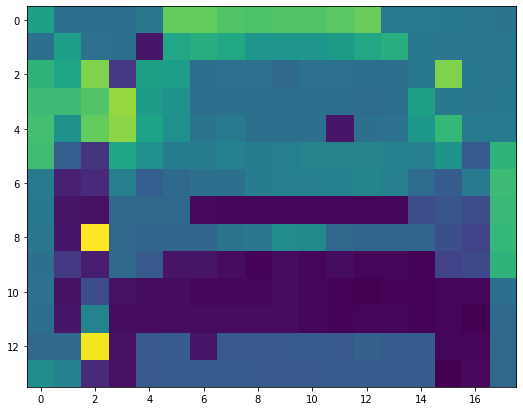

In [297]:
plt.imshow(img2)
plt.show()

### Optical flow